In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:

# Function to parse the file name and extract age and gender
def parse_filename(filename):
    """Parses filenames in the format age_gender_race_date.jpg"""
    filename = filename.split('.')[0]
    age, gender = filename.split('_')[:2]
    age = int(age)
    gender = int(gender)  # 0 for male, 1 for female
    return age, gender

# Function to load images and their labels
def load_utkface_data(data_dir, img_height, img_width):
    images = []
    age_labels = []
    gender_labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".jpg"):
            # Load and resize image
            img = cv2.imread(os.path.join(data_dir, filename))
            img = cv2.resize(img, (img_height, img_width))
            img = img / 255.0  # Normalize the image

            age, gender = parse_filename(filename)

            images.append(img)
            age_labels.append(age)
            gender_labels.append(gender)

    return np.array(images), np.array(age_labels), np.array(gender_labels)

# Load the UTKFace dataset
data_dir = 'C:\\Users\\Aseem\\Desktop\\LP-3\\MiniProject\\UTKFace'
img_height, img_width = 128, 128
images, ages, genders = load_utkface_data(data_dir, img_height, img_width)

# Check the shapes
print(f'Images: {images.shape}, Ages: {ages.shape}, Genders: {genders.shape}')


Images: (23708, 128, 128, 3), Ages: (23708,), Genders: (23708,)


In [3]:
age_bins = np.arange(0, 110, 10)  # Bins of 10 years each (0-10, 11-20, etc.)
age_labels = np.digitize(ages, bins=age_bins) - 1

ages = np.clip(ages, 0, 99)  # Keep ages between 0 and 99
age_labels = np.digitize(ages, bins=age_bins) - 1

In [4]:
def create_model():
    input_layer = Input(shape=(img_height, img_width, 3))

    # Convolutional base
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    # Gender output (binary classification)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

    # Age output (multi-class classification, based on age bins)
    age_output = Dense(len(age_bins) - 1, activation='softmax', name='age_output')(x)

    model = Model(inputs=input_layer, outputs=[gender_output, age_output])

    return model

In [5]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'sparse_categorical_crossentropy'},
              metrics={'gender_output': 'accuracy', 'age_output': 'accuracy'})

In [6]:
history = model.fit(
    images, 
    {'gender_output': genders, 'age_output': age_labels},
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 95s 154ms/step - age_output_accuracy: 0.4138 - gender_output_accuracy: 0.7755 - loss: 5.1379 - val_age_output_accuracy: 0.1229 - val_gender_output_accuracy: 0.7959 - val_loss: 18.1692
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 88s 149ms/step - age_output_accuracy: 0.4925 - gender_output_accuracy: 0.8598 - loss: 2.8967 - val_age_output_accuracy: 0.0738 - val_gender_output_accuracy: 0.8212 - val_loss: 32.1595
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 88s 148ms/step - age_output_accuracy: 0.5750 - gender_output_accuracy: 0.8957 - loss: 1.5498 - val_age_output_accuracy: 0.0333 - val_gender_output_accuracy: 0.6082 - val_loss: 47.6533
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 87s 147ms/step - age_output_accuracy: 0.6180 - gender_output_accuracy: 0.9127 - loss: 1.1728 - val_age_output_accuracy: 0.1215 - val_gender_output_accuracy: 0.8368 - val_loss: 13.4912
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 88s 148ms/step - age_output_accuracy: 0.6769 - gender_output_acc

In [7]:
def predict_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_height, img_width))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    gender_pred, age_pred = model.predict(img)
    
    gender = 'Male' if gender_pred[0] > 0.5 else 'Female'
    age_bin = np.argmax(age_pred)
    predicted_age_range = f"{age_bins[age_bin]}-{age_bins[age_bin+1]-1}"

    return gender, predicted_age_range

# Example prediction
gender, age_range = predict_image("C:\\Users\\Aseem\\Desktop\\LP-3\\MiniProject\\UTKFace\\49_1_0_20170109220421978.jpg.chip.jpg", model)
print(f"Predicted Gender: {gender}, Predicted Age Range: {age_range}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted Gender: Male, Predicted Age Range: 50-59


741/741 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step
Gender Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12391
           1       0.97      0.95      0.96     11317

    accuracy                           0.96     23708
   macro avg       0.96      0.96      0.96     23708
weighted avg       0.96      0.96      0.96     23708

Age Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      3062
           1       0.72      0.95      0.82      1531
           2       0.96      0.88      0.91      7344
           3       0.73      0.97      0.84      4537
           4       0.65      0.92      0.76      2245
           5       0.51      0.69      0.59      2299
           6       0.00      0.00      0.00      1318
           7       0.00      0.00      0.00       699
           8       0.00      0.00      0.00       504
           9       0.32      0.4

c:\Users\Aseem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aseem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aseem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

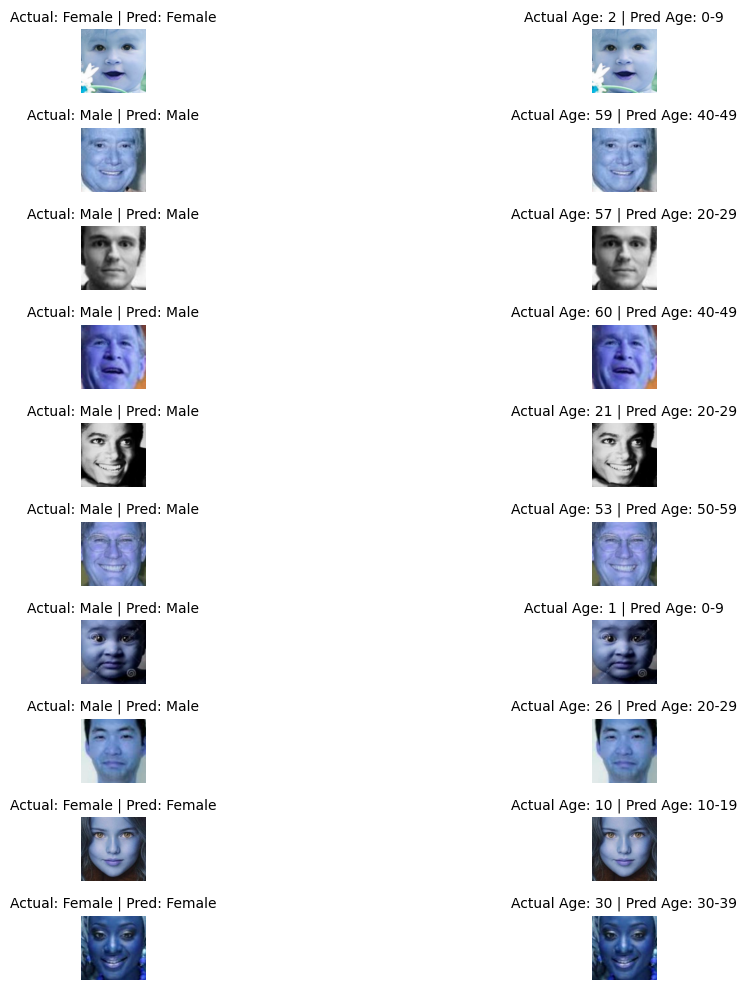

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Make predictions
predictions = model.predict(images)
predicted_genders = (predictions[0] > 0.5).astype(int)  # Threshold for gender
predicted_ages = np.argmax(predictions[1], axis=1)  # Class with highest probability for age

# Print classification report for gender
print("Gender Classification Report:")
print(classification_report(genders, predicted_genders))

# Print classification report for age
print("Age Classification Report:")
print(classification_report(age_labels, predicted_ages))

# Function to visualize actual vs predicted
def visualize_predictions(actual_genders, predicted_genders, actual_ages, predicted_ages, num_samples=10):
    # Ensure inputs are NumPy arrays for consistent indexing
    actual_genders = np.array(actual_genders)
    predicted_genders = np.array(predicted_genders)
    actual_ages = np.array(actual_ages)
    predicted_ages = np.array(predicted_ages)

    # Debugging: Print shapes and types of inputs
    print(f"actual_genders shape: {actual_genders.shape}, dtype: {actual_genders.dtype}")
    print(f"predicted_genders shape: {predicted_genders.shape}, dtype: {predicted_genders.dtype}")
    print(f"actual_ages shape: {actual_ages.shape}, dtype: {actual_ages.dtype}")
    print(f"predicted_ages shape: {predicted_ages.shape}, dtype: {predicted_ages.dtype}")

    indices = np.random.choice(len(actual_genders), num_samples, replace=False)
    plt.figure(figsize=(15, 10))  # Increase figure size for better readability

    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 2, i * 2 + 1)  # Adjust subplot layout for gender
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Actual: {['Male', 'Female'][int(actual_genders[idx])]} | Pred: {['Male', 'Female'][int(predicted_genders[idx])]}",
                  fontsize=10)

        plt.subplot(num_samples, 2, i * 2 + 2)  # Adjust subplot layout for age
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Actual Age: {actual_ages[idx]} | Pred Age: {age_bins[predicted_ages[idx]]}-{age_bins[predicted_ages[idx]+1]-1}",
                  fontsize=10)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Visualize predictions
visualize_predictions(genders, predicted_genders, ages, predicted_ages)
